In [20]:
import os
import glob
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
%matplotlib inline
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.tfutils.Modeltrainer import VideoTrainer
from werdich_cfr.utils.visuals import ImageSliceViewer3D

### Recover data from TFRecords: look at the postprocessed images ###

In [21]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200227'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date)
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'cfr_resized75_a4c_train_200227_0.tfrecords')
parquet_file = os.path.join(tfr_dir, 'cfr_resized75_a4c_train_200227_0.parquet')

# Load df 
df = pd.read_parquet(parquet_file)
df.head(50)

,study,mrn,echo_study_date,mrnstudyid,days_post_cfr,cfr_study_date,petmrn_identifier,post-2018,myocardial_perfusion,global_cfr_calc,unaffected_cfr,rest_mbf_unaff,stress_mbf_unaff,num_unaffected_segs,rest_global_mbf,stress_global_mbf,filename,dir,datetime,fileid,institution,model,manufacturer,index,frame_time,number_of_frames,heart_rate,deltaX,deltaY,a2c,a2c_laocc,a2c_lvocc_s,a3c,a3c_laocc,a3c_lvocc_s,a4c,a4c_far,a4c_laocc,a4c_lvocc_s,a4c_rv,a4c_rv_laocc,a5c,apex,other,plax_far,plax_lac,plax_laz,plax_laz_ao,plax_plax,psax_avz,psax_az,psax_mv,psax_pap,rvinf,subcostal,suprasternal,max_view,mode,rate,im_array_shape
83072,48b5fd769a91d147_4903a58051d4f8966700147fdaa8,30446694,2015-10-16,2546,113,2015-06-25,30446694_2015-06-25,0,normal,0.874720,0.861860,0.495235,0.426824,17,0.447,0.391,48b5fd769a91d147_4903a58051d4f8966700147fdaa8_...,/mnt/obi0/phi/echo/npyFiles/BWH/48b5/48b5fd769...,2015-10-16 13:17:33,48b5fd769a91d147_4903a58051d4f8966700147fdaa8_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,79.0,62.0,0.041843,0.041843,1.822032e-12,1.842830e-13,4.468732e-15,1.587738e-16,1.599482e-17,4.631794e-14,1.000000,8.657490e-14,1.527595e-15,6.530631e-14,3.805865e-09,2.805405e-14,1.760342e-14,1.009979e-15,8.429039e-16,9.352581e-16,5.891162e-14,8.060038e-14,2.171671e-16,8.921743e-16,4.968008e-09,1.112312e-09,8.910137e-14,2.173569e-12,1.824187e-17,8.222105e-16,3.422463e-14,a4c,train,30.0,"[188, 251, 40]"
85962,4b79caa91cfbe3cf_4903a444c3097211ab5363109b3c,2784734,2007-01-10,247,-1,2007-01-11,2784734_2007-01-11,0,normal,1.583531,1.573033,2.100588,3.304294,17,2.113,3.346,4b79caa91cfbe3cf_4903a444c3097211ab5363109b3c_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b79/4b79caa91...,2007-01-10 14:27:07,4b79caa91cfbe3cf_4903a444c3097211ab5363109b3c_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,91.0,64.0,0.037483,0.037483,1.265544e-05,2.836175e-10,3.280895e-11,7.583487e-10,9.152086e-11,6.673751e-11,0.999851,9.299940e-10,3.445852e-15,8.852129e-12,3.655906e-09,1.879712e-12,1.359658e-04,5.169882e-10,3.755842e-12,5.817911e-10,1.687673e-10,3.159999e-08,6.472791e-11,4.987319e-13,2.430797e-09,1.546010e-10,1.179633e-11,9.330643e-10,7.754600e-12,2.726941e-17,2.626584e-13,a4c,train,30.0,"[169, 225, 40]"
87072,4a1ed0fbef46628d_4903a58584260ad5eb519ccc099d,18264176,2010-08-11,1536,0,2010-08-11,18264176_2010-08-11,0,normal,1.394958,1.386461,0.848118,1.175882,17,0.833,1.162,4a1ed0fbef46628d_4903a58584260ad5eb519ccc099d_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a1e/4a1ed0fbe...,2010-08-11 10:40:30,4a1ed0fbef46628d_4903a58584260ad5eb519ccc099d_...,BWH,iE33,Philips Medical Systems,0.0,33.333000,73.0,70.0,0.044038,0.044038,2.338035e-17,2.589541e-12,6.970457e-15,2.056529e-15,8.040683e-16,2.691897e-14,1.000000,1.345874e-10,2.124468e-14,2.336193e-14,1.290132e-10,1.208972e-14,8.049895e-15,3.322668e-14,6.058303e-15,1.019681e-14,3.220240e-16,2.820702e-14,1.025289e-16,4.531647e-15,3.053699e-12,1.224628e-10,1.702797e-15,5.630916e-10,3.109424e-15,1.857392e-18,1.407088e-15,a4c,train,30.0,"[198, 264, 40]"
18865,4b7293dc48acfa62_4903a5805096e08ee8e572685c00,9038498,2015-01-29,800,-1,2015-01-30,9038498_2015-01-30,0,abnormal,1.148400,1.848282,0.661000,1.221714,7,1.031,1.184,4b7293dc48acfa62_4903a5805096e08ee8e572685c00_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b72/4b7293dc4...,2015-01-29 10:39:12,4b7293dc48acfa62_4903a5805096e08ee8e572685c00_...,BWH,Vivid S6,GE Healthcare,0.0,33.398244,78.0,73.0,0.045564,0.045564,6.576277e-07,1.150888e-06,2.112880e-07,7.261723e-08,7.706927e-10,2.912131e-07,0.999011,8.878765e-09,4.992289e-10,1.238030e-07,6.183735e-07,3.708711e-09,3.059526e-08,9.049451e-08,2.048708e-04,4.343941e-10,1.463853e-08,2.970797e-07,1.195732e-10,1.172088e-06,6.878491e-04,9.249641e-07,7.231976e-08,8.648080e-05,3.503815e-06,3.272938e-09,6.739079e-08,a4c,train,29.9,"[144, 217, 40]"
78694,48b09016b25a7f36_4903a58dd44b7b81d524809aba5f,35133560,2018-11-02,2618,191,2018-04-25,35133560_2018-04-25,0,normal,1.716143,1.699871,0.934766,1.588982,17,0.923,1.584,48b09016b25a7f36_4903a58dd44b7b81d524809

### Percentile thresholds for classification and image sizes ###

In [22]:
# TFR .parquet data files
train_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized75_a4c_train_200227_*.parquet'))
eval_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized75_a4c_eval_200227_*.parquet'))
test_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized75_a4c_test_200227_*.parquet'))

train_df = pd.concat([pd.read_parquet(file) for file in train_files])
eval_df = pd.concat([pd.read_parquet(file) for file in eval_files])
test_df = pd.concat([pd.read_parquet(file) for file in test_files])
dset = pd.concat([train_df, eval_df, test_df], axis = 0, ignore_index=True).reset_index(drop=True)
print(dset.shape)

(4026, 60)


In [23]:
print('Size of cfr table:', dset.shape)
cfr_array = dset.unaffected_cfr.values
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
print('Percentile boundaries:', p_list)

Size of cfr table: (4026, 60)
Percentile boundaries: [1.381, 1.729, 2.208]


In [24]:
percentile_list = p_list
def cfr_p_label(cfr_value):
    return np.digitize(cfr_value, bins = percentile_list)
# Setting the threshold, check the number of positives and negatives
df['labelp'] = df['unaffected_cfr'].apply(cfr_p_label)
print(df.labelp.iloc[0:10].values)

[0 1 1 2 1 0 0 2 3 3]


In [25]:
def cfr_label(cfr_value):
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    
    for p in range(1, len(percentile_list)):
        
        if (cfr_value >= percentile_list[p-1]) & (cfr_value < percentile_list[p]):
            label = p
    
    return label

df['label'] = df['unaffected_cfr'].apply(cfr_label)
print(df.label.iloc[0:10].values)

[0 1 1 2 1 0 0 2 3 3]


In [26]:
label_list = sorted(df.label.unique())
print('Unique labels:', label_list)
df.head(20)
# Number of samples in each group
samples = [df[df.label == l].shape[0] for l in label_list]
for l in label_list:
    print('Label:', l, 'samples:', samples[l])

Unique labels: [0, 1, 2, 3]
Label: 0 samples: 377
Label: 1 samples: 370
Label: 2 samples: 351
Label: 3 samples: 393


### TFR extraction and postprocessing ###

In [27]:
n_frames=40
cfr_boundaries=(1.232, 1.556, 2.05)
output_height=299
output_width=299
#im_scale_factor=0.5642
im_scale_factor=1.177
model_outputs=False #False returns all outputs
batch_size=8

In [28]:
@tf.function
def cfr_label(cfr_value):
    ''' classification label for cfr value '''
    percentile_list = cfr_boundaries
    label = 0
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    for p in range(1, len(percentile_list)):
        if (cfr_value >= percentile_list[p - 1]) & (cfr_value < percentile_list[p]):
            label = p
    return tf.one_hot(label, depth = len(percentile_list)+1)

In [29]:
def parse(serialized):

    example = {'image': tf.io.FixedLenFeature([], tf.string),
               'shape': tf.io.FixedLenFeature([], tf.string),
               'cfr': tf.io.FixedLenFeature([], tf.float32),
               'rest_mbf': tf.io.FixedLenFeature([], tf.float32),
               'stress_mbf': tf.io.FixedLenFeature([], tf.float32),
               'record': tf.io.FixedLenFeature([], tf.int64)}

    # Extract example from the data record
    example = tf.io.parse_single_example(serialized, example)

    # Convert image to tensor and shape it
    image_raw = tf.io.decode_raw(example['image'], tf.uint16)
    shape = tf.io.decode_raw(example['shape'], tf.uint16)
    shape = tf.cast(shape, tf.int32) # tf.reshape requires int16 or int32 types
    image = tf.reshape(image_raw, shape)

    # Here, we have recovered the original shape of the images.
    # Now we need to process them.

    cfr = example['cfr']
    rest_mbf = example['rest_mbf']
    stress_mbf = example['stress_mbf']
    record = example['record']

    # categorical and regression outputs (tuple of dicts)

    if model_outputs:
        # Training outputs: Only what the model needs
        outputs = ({'video': process_image(image, shape)},
                   {'score_output': cfr})
    else:
        # Enable all other outputs
        outputs = ({'video': process_image(image, shape)},
                   {'class_output': cfr_label(cfr),
                    'score_output': cfr,
                    'mbf_output': rest_mbf},
                   {'record': record})

    return outputs

In [30]:
def process_image(image, shape):

    # original shape is [height, width, frames] -> [frames, height, width, 1]
    # If there is no scale-factor, the images will be resized to fit
    image = tf.reshape(image, shape=shape)
    image = tf.transpose(image, perm=[2, 0, 1])
    image = tf.expand_dims(image, axis=-1)

    if im_scale_factor is None:
        image = tf.image.resize_with_pad(image,
                                         target_height=output_height,
                                         target_width=output_width)
    else:
        # Re-size the image with a single scale factor, then pad to output_size
        im_size = tf.cast(tf.slice(shape, [0], [2]), dtype=tf.float32)
        new_im_size = tf.cast(tf.math.ceil(tf.math.scalar_mul(im_scale_factor, im_size)), tf.int32)
        image = tf.image.resize(image, size=new_im_size, antialias=True)
        # Crop or pad to the output size
        image = tf.image.resize_with_crop_or_pad(image,
                                                 target_height=output_height,
                                                 target_width=output_width)

    # Scale image to have mean 0 and variance 1
    #image = tf.cast(image, tf.float64)
    image = tf.cast(image, tf.float32)
    image = tf.image.adjust_contrast(image, contrast_factor=5)
    output_image = tf.image.per_image_standardization(image)

    return output_image

In [31]:
dataset = tf.data.TFRecordDataset([tfr_file])
        
# Parse records
dataset = dataset.map(map_func=parse, num_parallel_calls = None)

# Batch it up
dataset = dataset.batch(batch_size, drop_remainder=True)

# Prefetch
#dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset = dataset.repeat(count=1)

In [32]:
for out in dataset.take(1):
    output = out

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
print('Input keys: ', output[0].keys())
print('Output keys:', output[1].keys())
image_batch = output[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)
class_label_batch = output[1]['class_output'].numpy()
print('Class batch output shape:', class_label_batch.shape)
cfr_batch = output[1]['score_output'].numpy()
mbf_batch = output[1]['mbf_output'].numpy()
print('CFR batch output shape:', cfr_batch.shape)

Input keys:  dict_keys(['video'])
Output keys: dict_keys(['class_output', 'score_output', 'mbf_output'])
Video batch shape: (8, 40, 299, 299, 1)
Class batch output shape: (8, 4)
CFR batch output shape: (8,)


In [33]:
print(mbf_batch)

[0.4952353  2.1005883  0.84811765 0.661      0.93476593 0.34275
 1.059      0.7044273 ]


In [34]:
print(df.rest_mbf_unaff.iloc[:batch_size])

83072    0.495235
85962    2.100588
87072    0.848118
18865    0.661000
78694    0.934766
40396    0.342750
8917     1.059000
31128    0.704427
Name: rest_mbf_unaff, dtype: float64


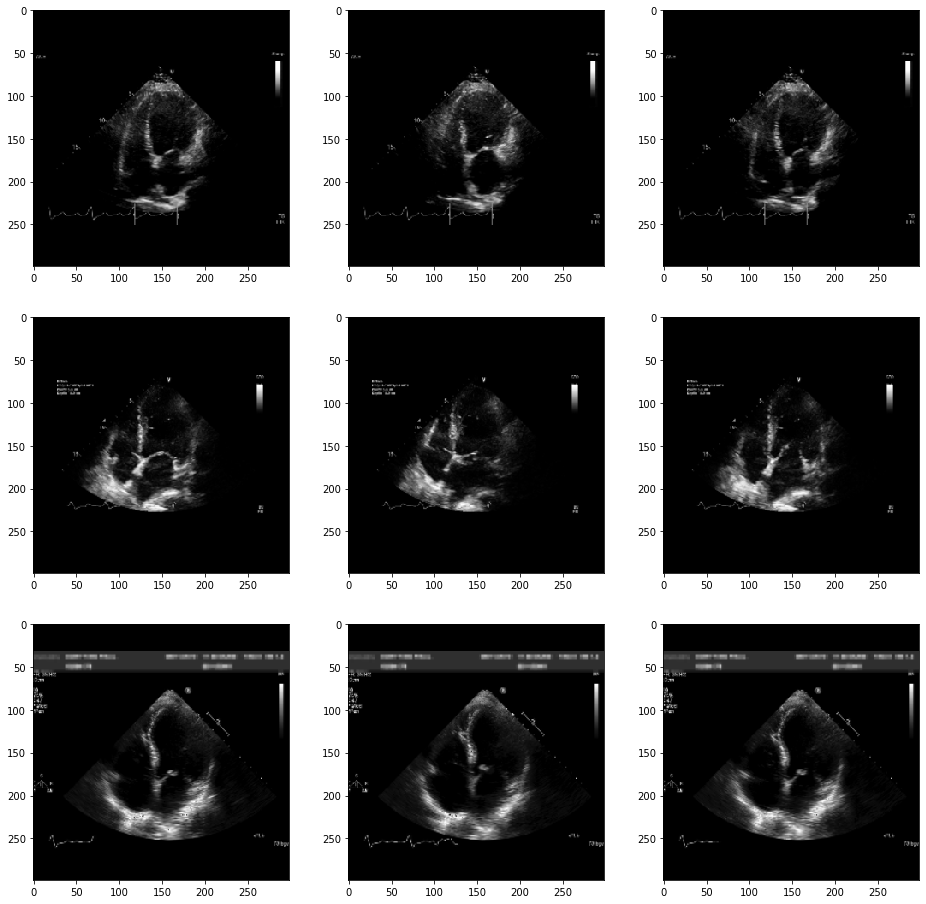

In [35]:
# Show some images from the batch
sample_idx = np.random.randint(batch_size, size=3)
frame_idx = np.random.randint(n_frames, size=3)

fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16,16))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')

### Sample output from the DatasetProvider class ###

In [36]:
# Parameters
batch_size=16

# Dataset
dset_provider = DatasetProvider(output_height=299,
                                output_width=299,
                                im_scale_factor=1.177,
                                model_outputs=True)


dset = dset_provider.make_batch([tfr_file], 
                                batch_size=batch_size,
                                shuffle=True,
                                buffer_n_batches=2,
                                repeat_count=1,
                                drop_remainder=True)

for out in dset.take(1):
    output = out
    
image_batch = output[0]['video'].numpy()

In [37]:
image_batch.shape

(16, 40, 299, 299, 1)

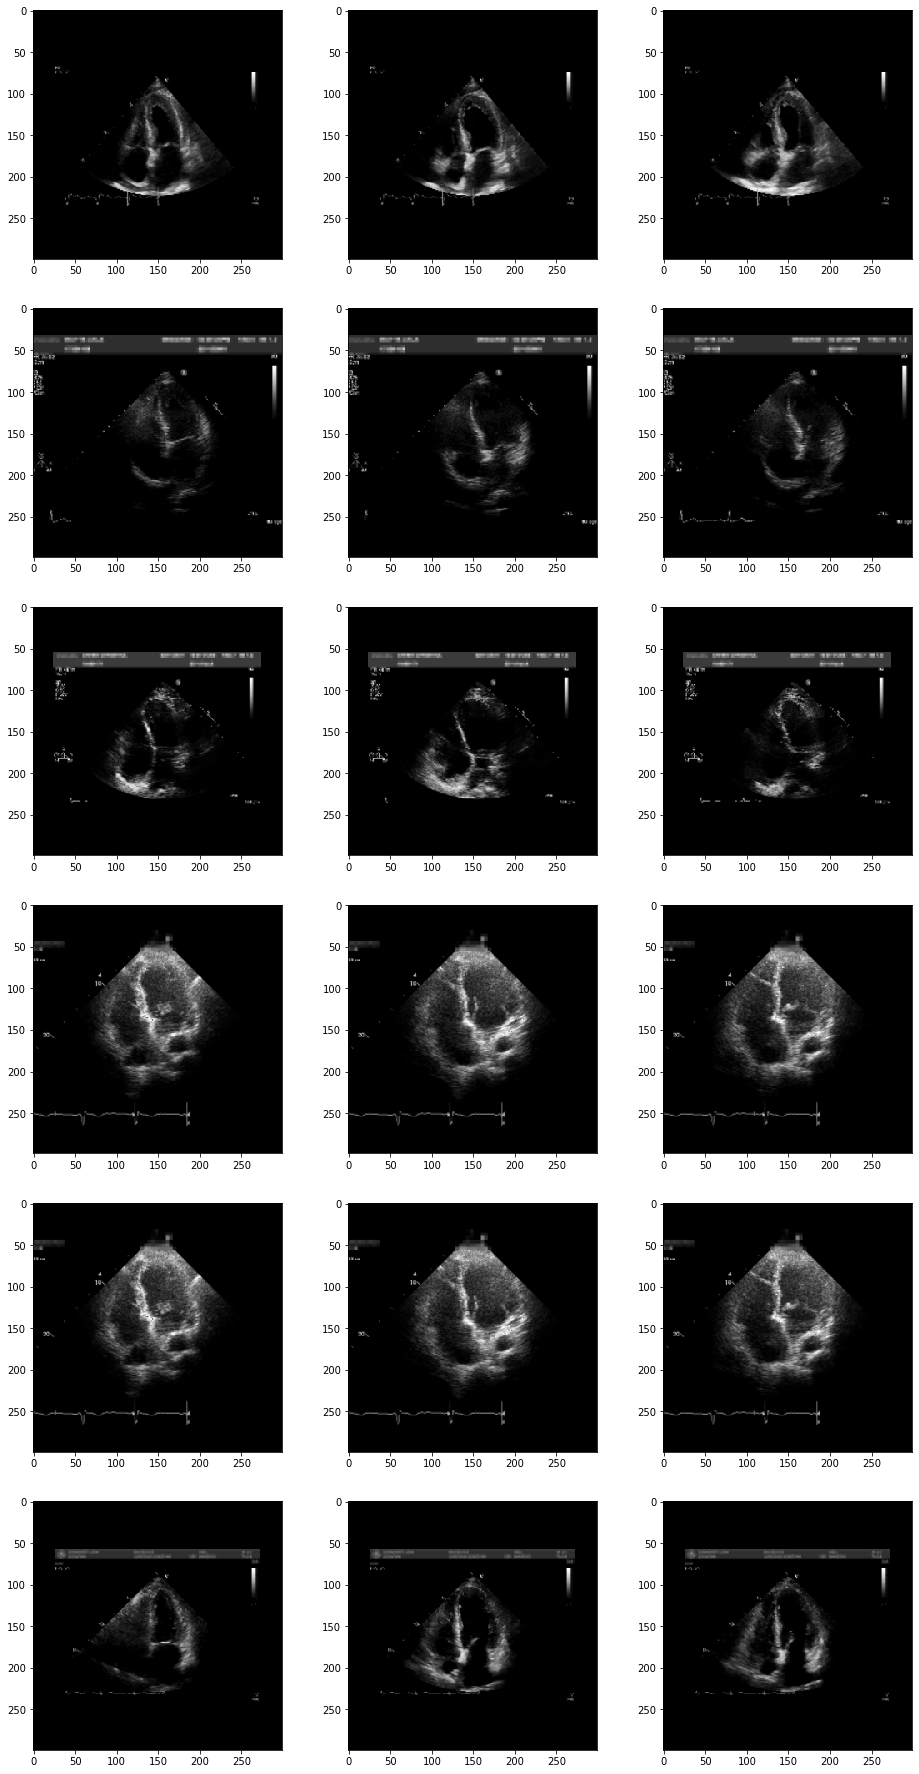

In [39]:
# Show some images from the batch
sample_idx = np.random.randint(batch_size, size=6)
frame_idx = np.random.randint(n_frames, size=3)

fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16,32))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')